In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import qmc
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

2025-07-02 15:09:52.043972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 15:09:52.055316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751490592.065128   22188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751490592.067890   22188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-02 15:09:52.081852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# path

loaded_emulator_laimax = tf.saved_model.load('./emulators/laimax_gmean/')
loaded_emulator_gpp = tf.saved_model.load('./emulators/gpp_gmean/')
loaded_emulator_biomass = tf.saved_model.load('./emulators/biomass_gmean/')


2025-07-02 15:10:44.256508: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
def callCLM(params,ix):
    # initialize sample with default CLM parameter set
    sample = np.array([0.8737026 , 0.14630213, 0.37171737, 0.27391456, 0.46666708,
       0.51924798, 0.46736367, 0.68843046, 0.61951923, 0.07068093,
       0.23517169, 0.17849673, 0.83990038, 0.10616273, 0.44688065,
       0.57367004, 0.30371528, 0.91975309, 0.71671051, 0.51094701,
       0.61565899, 0.26983746, 0.93698915, 0.02468359, 0.05703913,
       0.61071442, 0.461464  , 0.11014087, 0.71658162, 0.99813995,
       0.19665675, 0.71452042])

    sample[ix] = params
    
    y_pred_laimax, y_pred_var_laimax = loaded_emulator_laimax.compiled_predict_f(sample.reshape(1,-1))
    y_pred_gpp, y_pred_var_gpp = loaded_emulator_gpp.compiled_predict_f(sample.reshape(1,-1))
    y_pred_biomass, y_pred_var_biomass = loaded_emulator_biomass.compiled_predict_f(sample.reshape(1,-1))
    
    return y_pred_laimax.numpy().flatten(), y_pred_gpp.numpy().flatten(), y_pred_biomass.numpy().flatten()

In [9]:
# get LHC PPE parameter sets 
lhckey = './utils/lhc220926.txt'
ppe_params = pd.read_csv(lhckey).drop(columns='member')

tuning_params = ['FUN_fracfixers','froot_leaf','jmaxb0','jmaxb1','kmax','leafcn','medlynintercept','medlynslope','slatop','wc2wjb0']

num_params = len(tuning_params)
# params = np.random.rand(1, num_params)
ix = [ppe_params.columns.get_loc(col) for col in tuning_params]
# ix

In [10]:
### Normalize both the emulator outputs and the target values in order to have a fair weight between the different variables.
### The target values are the midpoints of the ranges (provided by Linnia)

def objective(params):
    laimax, gpp, biomass = callCLM(params, ix)

    # Target values and normalization bounds
    lai_min, lai_mid, lai_max = 1.55, 1.94, 2.32
    gpp_min, gpp_mid, gpp_max = 115, 127.5, 140
    biomass_min, biomass_mid, biomass_max = 375, 397.5, 420

    target_lai = (lai_mid - lai_min) / (lai_max - lai_min)
    target_gpp = (gpp_mid - gpp_min) / (gpp_max - gpp_min)
    target_biomass = (biomass_mid - biomass_min) / (biomass_max - biomass_min)

    # Normalize model outputs
    laimax = (laimax - lai_min) / (lai_max - lai_min)
    gpp = (gpp - gpp_min) / (gpp_max - gpp_min)
    biomass = (biomass - biomass_min) / (biomass_max - biomass_min)

    # Compute squared error
    cost = (laimax - target_lai) ** 2 + (gpp - target_gpp) ** 2 + (biomass - target_biomass) ** 2
    #print(target_lai, laimax, target_gpp, gpp, target_biomass, biomass, cost)

    return cost


In [17]:
num_samples = 100  # Adjust as needed

sampler = qmc.LatinHypercube(d=10, seed=42)  # 3 parameters, fixed seed
initial_samples = sampler.random(n=num_samples)

print(initial_samples)

[[3.92260440e-01 6.45611216e-01 3.14140208e-02 3.73026320e-01
  4.90582265e-02 2.70243776e-01 5.92388603e-01 6.21393569e-02
  4.78718864e-01 3.25496141e-01]
 [3.76292020e-01 9.40732350e-01 2.23561349e-01 8.41772384e-01
  3.85565858e-01 8.27727613e-01 3.84454152e-01 3.19361827e-01
  6.11723688e-01 7.13683356e-01]
 [9.52419123e-01 2.76454740e-01 1.10293020e-01 1.10687888e-02
  2.22161650e-02 4.18053613e-01 7.53327900e-02 9.89561962e-01
  2.98457105e-01 6.53169510e-01]
 [8.82552378e-01 9.20324903e-01 8.67417464e-02 4.16295403e-01
  3.75304442e-01 7.88105286e-01 4.08700785e-01 1.45242951e-01
  7.73090651e-03 4.83301860e-01]
 [9.05628481e-01 5.71673218e-01 5.29973490e-02 1.56876334e-01
  8.41677402e-01 6.91952356e-01 1.56125216e-01 1.71167190e-02
  1.63175045e-01 3.18602475e-01]
 [1.58000918e-01 3.49926377e-01 1.21307562e-02 4.23351491e-01
  2.42948346e-01 3.32192710e-01 7.35410842e-01 6.64312588e-01
  3.38602030e-01 5.98854699e-01]
 [2.03315970e-01 7.75289038e-01 7.84347639e-01 6.92350011e

In [12]:
### Set all parameter bounds to 0-1 (this is the normalized range for the parameters)

In [20]:
# Store valid parameter values

valid_params = []
LAI = []

all_param_bounds = [(0, 1)] * 10

# Perform optimization for each sampled set
for init in initial_samples:
    #print(f"The initial set of parameters are: {init}")
    res = minimize(objective, init, method='Nelder-Mead', bounds=all_param_bounds)
    lai_value, gpp_value, biomass_value = callCLM(res.x, ix)
    #print(f"Optimized parameters: {res.x}, LAI: {lai_value}, GPP: {gpp_value}, biomass: {biomass_value}, Iterations: {res.nit}, Function evaluations: {res.nfev}")
    # Store parameters if LAI is within the desired range
    if 1.55 <= lai_value <= 2.32 and 115 <= gpp_value <= 140 and 375 <= biomass_value <= 420:
        valid_params.append(res.x)
        LAI.append(lai_value)

# Convert to NumPy array
valid_params = np.array(valid_params)

0.5064935064935066 [0.84132968] 0.5 [0.2720008] 0.5 [3.66641968] [10.19031247]
0.5064935064935066 [0.85928247] 0.5 [0.28520179] 0.5 [3.70415104] [10.4371822]
0.5064935064935066 [0.821098] 0.5 [0.2649294] 0.5 [3.63937] [10.00987818]
0.5064935064935066 [0.84458694] 0.5 [0.27518435] 0.5 [3.67602854] [10.2520065]
0.5064935064935066 [0.861462] 0.5 [0.28845982] 0.5 [3.75904363] [10.79211727]
0.5064935064935066 [0.85381442] 0.5 [0.28567413] 0.5 [3.70228582] [10.4212019]
0.5064935064935066 [0.82450204] 0.5 [0.2469335] 0.5 [3.60149859] [9.7844656]
0.5064935064935066 [0.84313582] 0.5 [0.26985826] 0.5 [3.71308223] [10.49019067]
0.5064935064935066 [0.8411141] 0.5 [0.26953424] 0.5 [3.66161578] [10.16089972]
0.5064935064935066 [0.85653482] 0.5 [0.26786524] 0.5 [3.65575276] [10.13519096]
0.5064935064935066 [0.85841436] 0.5 [0.29093751] 0.5 [3.76402247] [10.82139812]
0.5064935064935066 [0.83062239] 0.5 [0.25381282] 0.5 [3.58966186] [9.71167807]
0.5064935064935066 [0.81608727] 0.5 [0.23457877] 0.5 [3.4

KeyboardInterrupt: 

In [25]:
valid_params = np.array(valid_params)

### Play around with the valid parameter sets that were saved based on 50 different sets of initial parameters

In [ ]:
valid_params = np.load("valid_params.npy")

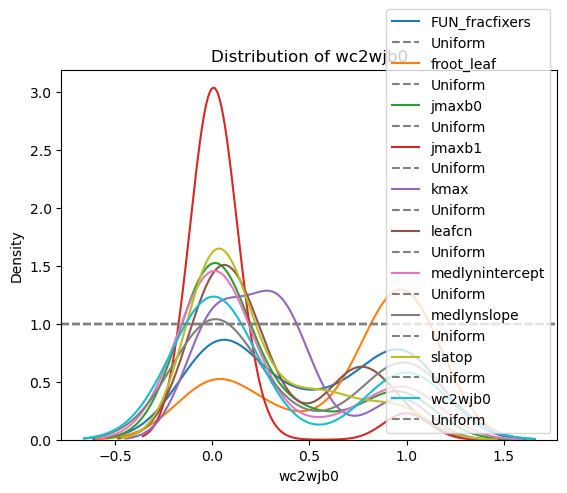

In [26]:
# valid_params

param_names = tuning_params

for i, name in enumerate(param_names):
    sns.kdeplot(valid_params[:, i], label=name)
    plt.title(f'Distribution of {name}')
    plt.xlabel(name)
    plt.ylabel('Density')
    plt.axhline(1, ls='--', color='gray', label='Uniform')
    plt.legend()
plt.show()


In [27]:
sample = np.array([0.8737026 , 0.14630213, 0.37171737, 0.27391456, 0.46666708,
    0.51924798, 0.46736367, 0.68843046, 0.61951923, 0.07068093,
    0.23517169, 0.17849673, 0.83990038, 0.10616273, 0.44688065,
    0.57367004, 0.30371528, 0.91975309, 0.71671051, 0.51094701,
    0.61565899, 0.26983746, 0.93698915, 0.02468359, 0.05703913,
    0.61071442, 0.461464  , 0.11014087, 0.71658162, 0.99813995,
    0.19665675, 0.71452042])

default_values = sample[ix]
default_values

array([0.8737026 , 0.46736367, 0.07068093, 0.23517169, 0.83990038,
       0.57367004, 0.51094701, 0.61565899, 0.05703913, 0.71452042])

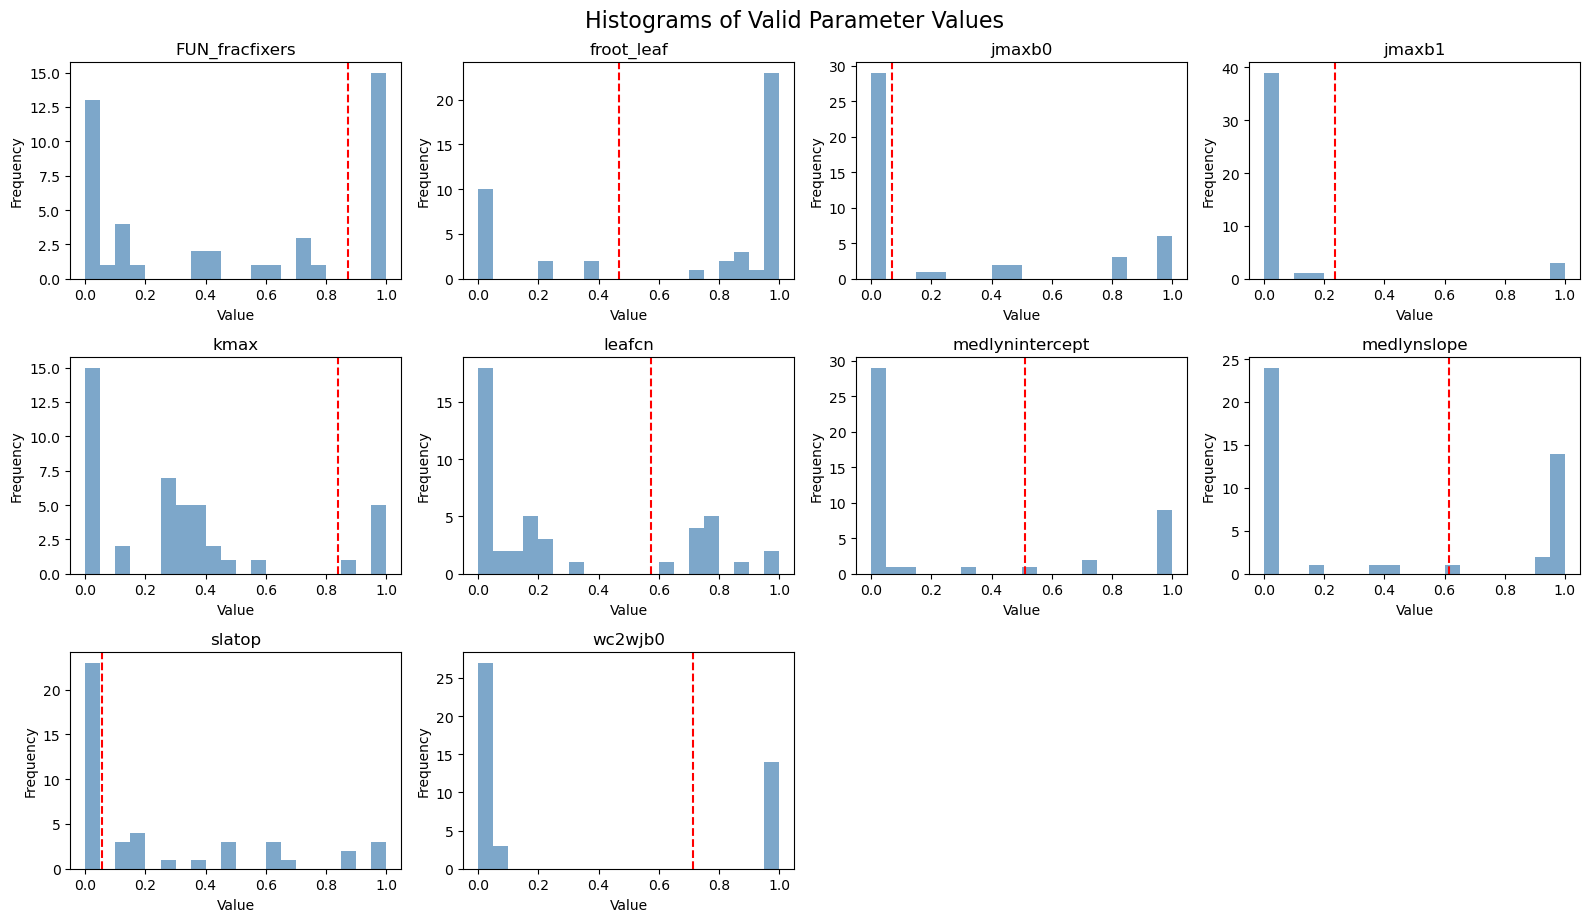

In [28]:
n_params = valid_params.shape[1]
n_cols = 4  # You can adjust this depending on how many plots per row you want
n_rows = (n_params + n_cols - 1) // n_cols  # Automatically determine the number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, name in enumerate(param_names):
    axes[i].hist(valid_params[:, i], bins=20, alpha=0.7, color='steelblue')
    axes[i].axvline(default_values[i], color='red', linestyle='--', label='Default')  
    axes[i].set_title(name)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Histograms of Valid Parameter Values', fontsize=16, y=1.02)
plt.show()